[I 2024-09-13 16:11:29,281] A new study created in memory with name: no-name-d0ca4916-505c-4126-ac35-3690214dad9b
[I 2024-09-13 16:11:30,880] Trial 0 finished with value: 891493530.8273064 and parameters: {'n_estimators': 209, 'max_depth': 7, 'learning_rate': 0.08925142616916862, 'subsample': 0.8997007025497823, 'colsample_bytree': 0.991791281129728}. Best is trial 0 with value: 891493530.8273064.
[I 2024-09-13 16:11:31,607] Trial 1 finished with value: 1089473591.5104003 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.28957501830167587, 'subsample': 0.9027510310749444, 'colsample_bytree': 0.5701572561357418}. Best is trial 0 with value: 891493530.8273064.
[I 2024-09-13 16:11:37,498] Trial 2 finished with value: 781684442.0906211 and parameters: {'n_estimators': 763, 'max_depth': 8, 'learning_rate': 0.19532236726193125, 'subsample': 0.6553787375842288, 'colsample_bytree': 0.6964058592555882}. Best is trial 2 with value: 781684442.0906211.
[I 2024-09-13 16:11:41

Best parameters: {'n_estimators': 534, 'max_depth': 3, 'learning_rate': 0.11274799036889568, 'subsample': 0.7956676282644791, 'colsample_bytree': 0.7970334739481869}
Mean Squared Error: 531283396.2671456


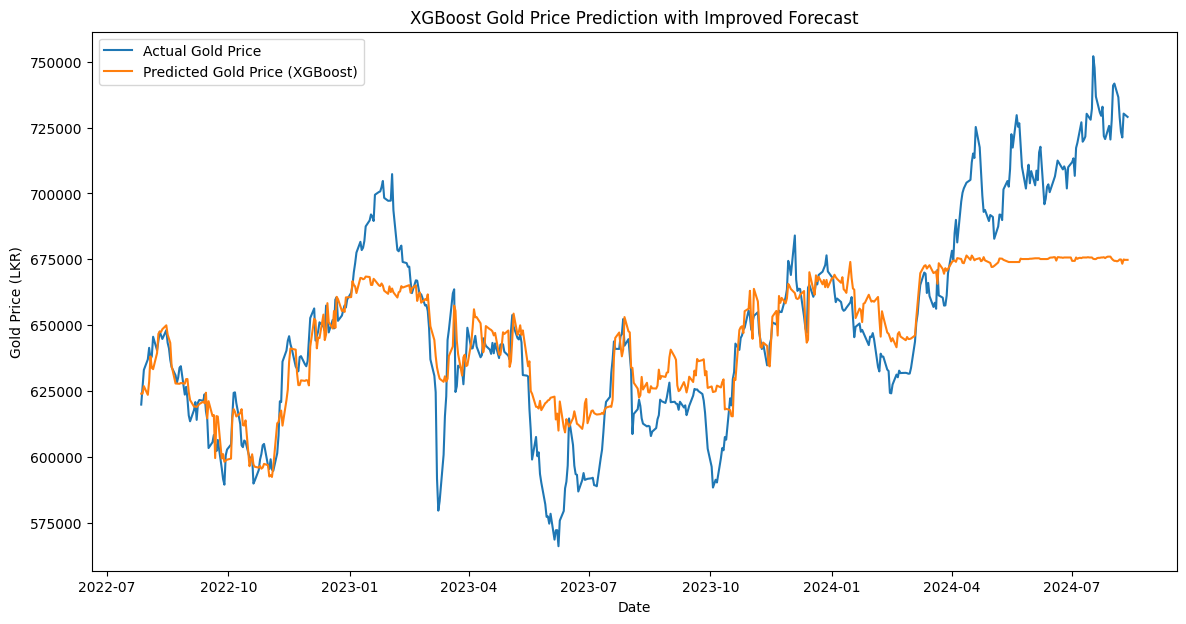

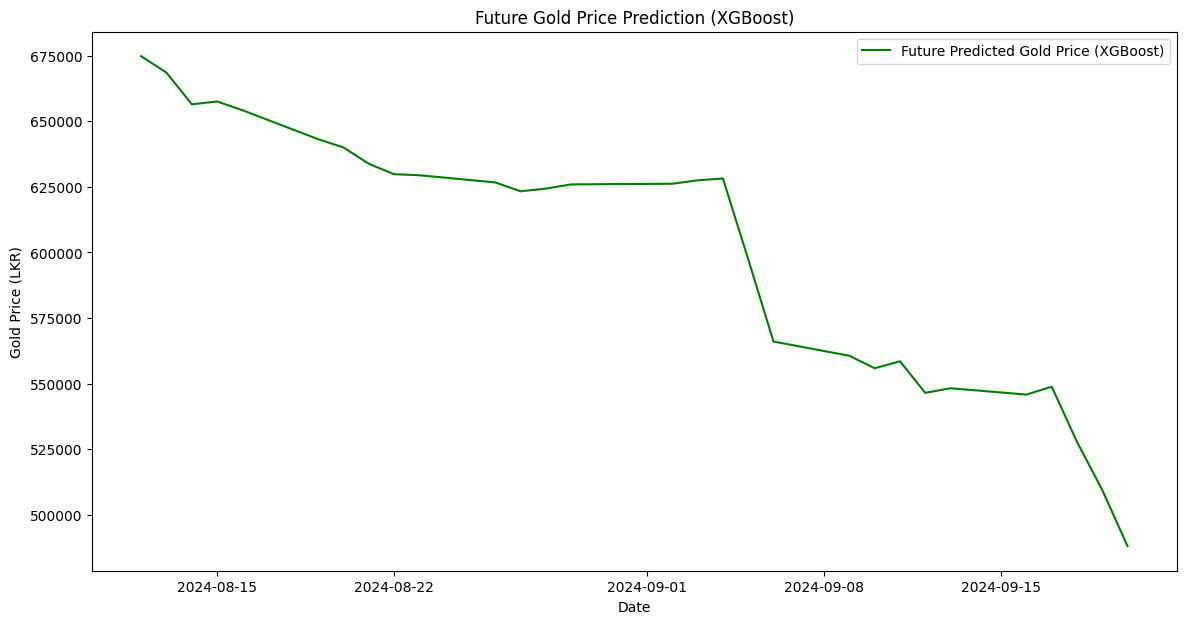

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import optuna

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select relevant columns
columns = ['date', 'gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].copy()

# Feature engineering: create lagged features (lag of 30 days)
def create_lagged_features(df, target_col, n_lags):
    df_copy = df.copy()
    for lag in range(1, n_lags + 1):
        df_copy[f'{target_col}_lag_{lag}'] = df_copy[target_col].shift(lag)
    return df_copy

# Define the lag
n_lags = 30  # 30 days lag

# Create lagged features for the target variable and other relevant variables
df_lagged = create_lagged_features(data, 'gold_lkr', n_lags)

# Create lagged features for other important features
for col in ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate']:
    df_lagged = create_lagged_features(df_lagged, col, n_lags)

# Drop rows with NaN values generated by the lagging
df_lagged = df_lagged.dropna()

# Define the features and the target variable
features = [col for col in df_lagged.columns if 'lag' in col]  # Lagged features only
target = 'gold_lkr'

# Split the data into features and target
X = df_lagged[features]
y = df_lagged[target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Hyperparameter tuning with Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

# Train the final XGBoost model using the best parameters
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot actual vs predicted values for the test set
plt.figure(figsize=(14, 7))
plt.plot(df_lagged['date'].iloc[-len(y_test):], y_test, label='Actual Gold Price')
plt.plot(df_lagged['date'].iloc[-len(y_test):], y_pred, label='Predicted Gold Price (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.title('XGBoost Gold Price Prediction with Improved Forecast')
plt.legend()
plt.show()

# Future prediction (next 30 days)
# Take the last available data point and create a future lag sequence for prediction
last_known_data = df_lagged.iloc[-1][features].values.reshape(1, -1)
future_predictions = []

# Predict for the next 30 days
for day in range(30):
    future_pred = xgb_model.predict(last_known_data)[0]
    future_predictions.append(future_pred)

    # Update the lagged features with the predicted value
    last_known_data = np.roll(last_known_data, -1)  # Shift the lagging window by 1 day
    last_known_data[0, -n_lags] = future_pred  # Add the new prediction to the lagged feature set

# Generate future dates for the next 30 days
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=30, freq='B')  # Business days for the next 30 days

# Plot future predictions
plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_predictions, label='Future Predicted Gold Price (XGBoost)', color='green')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.title('Future Gold Price Prediction (XGBoost)')
plt.legend()
plt.show()
